#**Step 01: Installing the Packages**

In [ ]:
%%capture
!pip install super-gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

#**Step 02: Importing all the required libraries**

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

[2024-03-04 14:04:17] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-03-04 14:04:17] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-04 14:04:17] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-03-04 14:04:31] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-04 14:04:31] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-04 14:04:31] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-03-04 14:04:31] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-03-04 14:04:31] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2024-03-04 14:04:31] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2024-03-04 14:04:31] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but not found
[2024-03-04 14:04:31] WARNING - env_sanity_check.py - Failed to verify i

In [ ]:
from IPython.display import clear_output

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:
from super_gradients.training import models

#**Step 03: Setting the checkpoint directory and experiment name | Instantiated the trainer**

In [ ]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='ppe_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

#**Step 04: Exporting the Dataset from Roboflow into the Google Colab Notebook**

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="Lz2dr2TeS22UaLY9epUI")
project = rf.workspace("huiyao-hu-sj18e").project("construction-ppe-detection")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Construction-PPE-Detection-1 in yolov5pytorch::   5%|▌         | 515/10034 [00:00<00:01, 5146.42it/s]

Extracting Dataset Version Zip to Construction-PPE-Detection-1 in yolov5pytorch::  85%|████████▍ | 8499/10034 [00:01<00:00, 8736.77it/s]

In [ ]:
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")
LOCATION = dataset.location
CLASSES = sorted(project.classes.keys())
print(CLASSES)
print(LOCATION)
print(EXPERIMENT_NAME)


#**Step 05: Load your dataset parameters into a dictionary**

In [ ]:
dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

#**Step 06: Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': CLASSES ,
        'class_inclusion_list': CLASSES   # Include this line to specify the classes to include
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes'],
        'class_inclusion_list': CLASSES   # Include this line to specify the classes to include
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes'],
        'class_inclusion_list': CLASSES  # Include this line to specify the classes to include
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

clear_output()


#**Step 07: Inspect the Dataset Defined Earlier**

In [ ]:
train_data.dataset.transforms

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

Indexing dataset annotations: 100%|██████████| 211/211 [00:00<00:00, 5379.57it/s]


{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

#**Step 08: Plot a batch of training data with their augmentations applied to see what they look like**

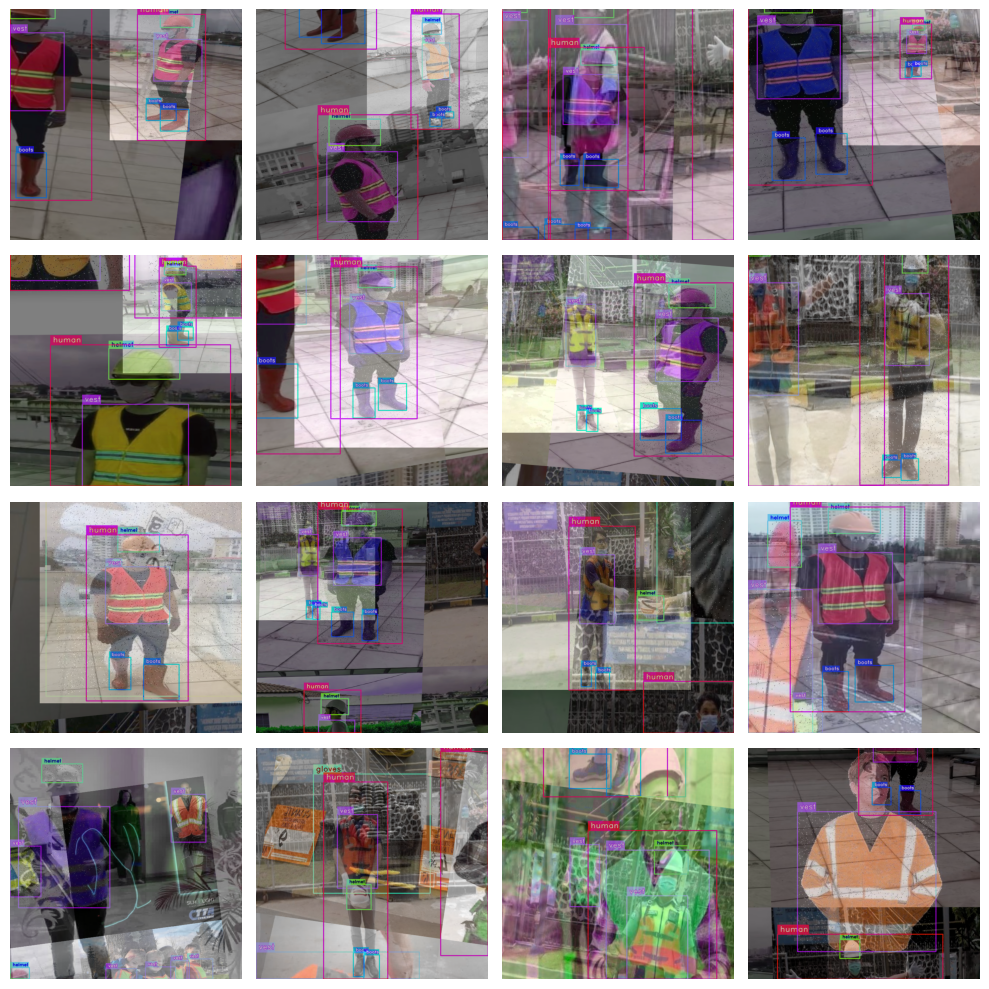

In [ ]:
train_data.dataset.plot()

#**Step 09: Instantiating the model**

In [ ]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-03-04 14:04:56] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 236MB/s]
[2024-03-04 14:04:57] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


#**Step 10: 📊 Define metrics and training parameters**


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    "random_seed": 42,
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 6e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.6,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.5,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.6
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#**Step 12: 🦾 Training the model**

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

Downloading...
From: https://drive.google.com/uc?id=1iYW9ZAsYAaHkWZhFVwQh_ch41TMt30-Q&confirm=t
To: /content/demonew2.mp4
100% 1.87M/1.87M [00:00<00:00, 144MB/s]


[2024-03-04 14:05:17] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240304_140517_967221`
[2024-03-04 14:05:17] INFO - sg_trainer.py - Checkpoints directory: checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221
[2024-03-04 14:05:17] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})


The console stream is now moved to checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/console_Mar04_14_05_17.txt


[2024-03-04 14:05:23] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            4377       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         273        (len(train_loader))
    - Gradient updates per epoch:   273        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.02M parameters, 19.02M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.02M parameters). LR: 0.0006 (19.02M parameters) WD: 0.0, (42.14K parameters), WD: 0.0001, (18.98M parameters)

[2024-03-04 14:05:23] INFO - sg_trainer.py - Started training for 1

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2437
│   ├── Ppyoloeloss/loss_iou = 0.6929
│   ├── Ppyoloeloss/loss_dfl = 0.7437
│   └── Ppyoloeloss/loss = 3.6804
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.2118
    ├── Ppyoloeloss/loss_iou = 0.5089
    ├── Ppyoloeloss/loss_dfl = 0.6184
    ├── Ppyoloeloss/loss = 3.3392
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.0



Validating epoch 1: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]
[2024-03-04 14:16:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 14:16:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6281091570854187


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.937
│   │   ├── Epoch N-1      = 2.2437 (↘ -1.3068)
│   │   └── Best until now = 2.2437 (↘ -1.3068)
│   ├── Ppyoloeloss/loss_iou = 0.4734
│   │   ├── Epoch N-1      = 0.6929 (↘ -0.2196)
│   │   └── Best until now = 0.6929 (↘ -0.2196)
│   ├── Ppyoloeloss/loss_dfl = 0.5458
│   │   ├── Epoch N-1      = 0.7437 (↘ -0.198)
│   │   └── Best until now = 0.7437 (↘ -0.198)
│   └── Ppyoloeloss/loss = 1.9561
│       ├── Epoch N-1      = 3.6804 (↘ -1.7243)
│       └── Best until now = 3.6804 (↘ -1.7243)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8162
    │   ├── Epoch N-1      = 2.2118 (↘ -1.3956)
    │   └── Best until now = 2.2118 (↘ -1.3956)
    ├── Ppyoloeloss/loss_iou = 0.3804
    │   ├── Epoch N-1      = 0.5089 (↘ -0.1285)
    │   └── Best until now = 0.5089 (↘ -0.1285)
    ├── Ppyoloeloss/loss_dfl = 0.4689
    │   ├── Epoch N-1      = 0.6184 (↘ -0.1495)
    │   └── Best until now = 0.6184 (↘ -0.1495)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 27/27 [00:11<00:00,  2.37it/s]
[2024-03-04 14:21:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 14:21:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6424806714057922


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8446
│   │   ├── Epoch N-1      = 0.937  (↘ -0.0924)
│   │   └── Best until now = 0.937  (↘ -0.0924)
│   ├── Ppyoloeloss/loss_iou = 0.4488
│   │   ├── Epoch N-1      = 0.4734 (↘ -0.0246)
│   │   └── Best until now = 0.4734 (↘ -0.0246)
│   ├── Ppyoloeloss/loss_dfl = 0.5215
│   │   ├── Epoch N-1      = 0.5458 (↘ -0.0243)
│   │   └── Best until now = 0.5458 (↘ -0.0243)
│   └── Ppyoloeloss/loss = 1.8149
│       ├── Epoch N-1      = 1.9561 (↘ -0.1412)
│       └── Best until now = 1.9561 (↘ -0.1412)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7931
    │   ├── Epoch N-1      = 0.8162 (↘ -0.0231)
    │   └── Best until now = 0.8162 (↘ -0.0231)
    ├── Ppyoloeloss/loss_iou = 0.3678
    │   ├── Epoch N-1      = 0.3804 (↘ -0.0126)
    │   └── Best until now = 0.3804 (↘ -0.0126)
    ├── Ppyoloeloss/loss_dfl = 0.4631
    │   ├── Epoch N-1      = 0.4689 (↘ -0.0058)
    │   └── Best until now = 0.4689 (↘ -0.0058)
    ├── Ppyoloeloss/lo

Validating epoch 3: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]
[2024-03-04 14:27:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 14:27:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6627087593078613


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8292
│   │   ├── Epoch N-1      = 0.8446 (↘ -0.0154)
│   │   └── Best until now = 0.8446 (↘ -0.0154)
│   ├── Ppyoloeloss/loss_iou = 0.4452
│   │   ├── Epoch N-1      = 0.4488 (↘ -0.0036)
│   │   └── Best until now = 0.4488 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.5143
│   │   ├── Epoch N-1      = 0.5215 (↘ -0.0072)
│   │   └── Best until now = 0.5215 (↘ -0.0072)
│   └── Ppyoloeloss/loss = 1.7887
│       ├── Epoch N-1      = 1.8149 (↘ -0.0262)
│       └── Best until now = 1.8149 (↘ -0.0262)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8185
    │   ├── Epoch N-1      = 0.7931 (↗ 0.0254)
    │   └── Best until now = 0.7931 (↗ 0.0254)
    ├── Ppyoloeloss/loss_iou = 0.3582
    │   ├── Epoch N-1      = 0.3678 (↘ -0.0096)
    │   └── Best until now = 0.3678 (↘ -0.0096)
    ├── Ppyoloeloss/loss_dfl = 0.452
    │   ├── Epoch N-1      = 0.4631 (↘ -0.0111)
    │   └── Best until now = 0.4631 (↘ -0.0111)
    ├── Ppyoloeloss/loss 

Validating epoch 4: 100%|██████████| 27/27 [00:10<00:00,  2.51it/s]
[2024-03-04 14:32:30] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 14:32:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.675146222114563


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7993
│   │   ├── Epoch N-1      = 0.8292 (↘ -0.0299)
│   │   └── Best until now = 0.8292 (↘ -0.0299)
│   ├── Ppyoloeloss/loss_iou = 0.4265
│   │   ├── Epoch N-1      = 0.4452 (↘ -0.0186)
│   │   └── Best until now = 0.4452 (↘ -0.0186)
│   ├── Ppyoloeloss/loss_dfl = 0.5008
│   │   ├── Epoch N-1      = 0.5143 (↘ -0.0135)
│   │   └── Best until now = 0.5143 (↘ -0.0135)
│   └── Ppyoloeloss/loss = 1.7266
│       ├── Epoch N-1      = 1.7887 (↘ -0.0621)
│       └── Best until now = 1.7887 (↘ -0.0621)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8182
    │   ├── Epoch N-1      = 0.8185 (↘ -0.0003)
    │   └── Best until now = 0.7931 (↗ 0.0251)
    ├── Ppyoloeloss/loss_iou = 0.3572
    │   ├── Epoch N-1      = 0.3582 (↘ -0.001)
    │   └── Best until now = 0.3582 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.4517
    │   ├── Epoch N-1      = 0.452  (↘ -0.0003)
    │   └── Best until now = 0.452  (↘ -0.0003)
    ├── Ppyoloeloss/loss 

Validating epoch 5: 100%|██████████| 27/27 [00:10<00:00,  2.48it/s]
[2024-03-04 14:38:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 14:38:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7034439444541931


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.779
│   │   ├── Epoch N-1      = 0.7993 (↘ -0.0203)
│   │   └── Best until now = 0.7993 (↘ -0.0203)
│   ├── Ppyoloeloss/loss_iou = 0.4146
│   │   ├── Epoch N-1      = 0.4265 (↘ -0.0119)
│   │   └── Best until now = 0.4265 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_dfl = 0.4923
│   │   ├── Epoch N-1      = 0.5008 (↘ -0.0085)
│   │   └── Best until now = 0.5008 (↘ -0.0085)
│   └── Ppyoloeloss/loss = 1.6858
│       ├── Epoch N-1      = 1.7266 (↘ -0.0408)
│       └── Best until now = 1.7266 (↘ -0.0408)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7926
    │   ├── Epoch N-1      = 0.8182 (↘ -0.0256)
    │   └── Best until now = 0.7931 (↘ -0.0005)
    ├── Ppyoloeloss/loss_iou = 0.3607
    │   ├── Epoch N-1      = 0.3572 (↗ 0.0035)
    │   └── Best until now = 0.3572 (↗ 0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.4524
    │   ├── Epoch N-1      = 0.4517 (↗ 0.0007)
    │   └── Best until now = 0.4517 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7619
│   │   ├── Epoch N-1      = 0.779  (↘ -0.017)
│   │   └── Best until now = 0.779  (↘ -0.017)
│   ├── Ppyoloeloss/loss_iou = 0.4052
│   │   ├── Epoch N-1      = 0.4146 (↘ -0.0094)
│   │   └── Best until now = 0.4146 (↘ -0.0094)
│   ├── Ppyoloeloss/loss_dfl = 0.4809
│   │   ├── Epoch N-1      = 0.4923 (↘ -0.0114)
│   │   └── Best until now = 0.4923 (↘ -0.0114)
│   └── Ppyoloeloss/loss = 1.6481
│       ├── Epoch N-1      = 1.6858 (↘ -0.0378)
│       └── Best until now = 1.6858 (↘ -0.0378)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8479
    │   ├── Epoch N-1      = 0.7926 (↗ 0.0553)
    │   └── Best until now = 0.7926 (↗ 0.0553)
    ├── Ppyoloeloss/loss_iou = 0.3476
    │   ├── Epoch N-1      = 0.3607 (↘ -0.0131)
    │   └── Best until now = 0.3572 (↘ -0.0096)
    ├── Ppyoloeloss/loss_dfl = 0.4419
    │   ├── Epoch N-1      = 0.4524 (↘ -0.0105)
    │   └── Best until now = 0.4517 (↘ -0.0098)
    ├── Ppyoloeloss/loss =

Validating epoch 7:  89%|████████▉ | 24/27 [00:09<00:01,  2.89it/s]

SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7447
│   │   ├── Epoch N-1      = 0.7619 (↘ -0.0173)
│   │   └── Best until now = 0.7619 (↘ -0.0173)
│   ├── Ppyoloeloss/loss_iou = 0.3933
│   │   ├── Epoch N-1      = 0.4052 (↘ -0.012)
│   │   └── Best until now = 0.4052 (↘ -0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.4707
│   │   ├── Epoch N-1      = 0.4809 (↘ -0.0102)
│   │   └── Best until now = 0.4809 (↘ -0.0102)
│   └── Ppyoloeloss/loss = 1.6086
│       ├── Epoch N-1      = 1.6481 (↘ -0.0395)
│       └── Best until now = 1.6481 (↘ -0.0395)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7061
    │   ├── Epoch N-1      = 0.8479 (↘ -0.1418)
    │   └── Best until now = 0.7926 (↘ -0.0865)
    ├── Ppyoloeloss/loss_iou = 0.3427
    │   ├── Epoch N-1      = 0.3476 (↘ -0.0048)
    │   └── Best until now = 0.3476 (↘ -0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.431
    │   ├── Epoch N-1      = 0.4419 (↘ -0.0109)
    │   └── Best until now = 0.4419 (↘ -0.0109)
    ├── Ppyoloeloss/loss 

Validating epoch 8: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]
[2024-03-04 14:54:26] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 14:54:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7164930701255798


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7325
│   │   ├── Epoch N-1      = 0.7447 (↘ -0.0121)
│   │   └── Best until now = 0.7447 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_iou = 0.3889
│   │   ├── Epoch N-1      = 0.3933 (↘ -0.0043)
│   │   └── Best until now = 0.3933 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.4659
│   │   ├── Epoch N-1      = 0.4707 (↘ -0.0048)
│   │   └── Best until now = 0.4707 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.5873
│       ├── Epoch N-1      = 1.6086 (↘ -0.0213)
│       └── Best until now = 1.6086 (↘ -0.0213)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7125
    │   ├── Epoch N-1      = 0.7061 (↗ 0.0064)
    │   └── Best until now = 0.7061 (↗ 0.0064)
    ├── Ppyoloeloss/loss_iou = 0.3384
    │   ├── Epoch N-1      = 0.3427 (↘ -0.0043)
    │   └── Best until now = 0.3427 (↘ -0.0043)
    ├── Ppyoloeloss/loss_dfl = 0.432
    │   ├── Epoch N-1      = 0.431  (↗ 0.001)
    │   └── Best until now = 0.431  (↗ 0.001)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 9: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]
[2024-03-04 14:59:56] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 14:59:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7358400225639343


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7219
│   │   ├── Epoch N-1      = 0.7325 (↘ -0.0106)
│   │   └── Best until now = 0.7325 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.381
│   │   ├── Epoch N-1      = 0.3889 (↘ -0.0079)
│   │   └── Best until now = 0.3889 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.4602
│   │   ├── Epoch N-1      = 0.4659 (↘ -0.0057)
│   │   └── Best until now = 0.4659 (↘ -0.0057)
│   └── Ppyoloeloss/loss = 1.5631
│       ├── Epoch N-1      = 1.5873 (↘ -0.0242)
│       └── Best until now = 1.5873 (↘ -0.0242)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7007
    │   ├── Epoch N-1      = 0.7125 (↘ -0.0118)
    │   └── Best until now = 0.7061 (↘ -0.0054)
    ├── Ppyoloeloss/loss_iou = 0.3324
    │   ├── Epoch N-1      = 0.3384 (↘ -0.006)
    │   └── Best until now = 0.3384 (↘ -0.006)
    ├── Ppyoloeloss/loss_dfl = 0.422
    │   ├── Epoch N-1      = 0.432  (↘ -0.01)
    │   └── Best until now = 0.431  (↘ -0.009)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 10: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]
[2024-03-04 15:05:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 15:05:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7541111707687378


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7018
│   │   ├── Epoch N-1      = 0.7219 (↘ -0.0201)
│   │   └── Best until now = 0.7219 (↘ -0.0201)
│   ├── Ppyoloeloss/loss_iou = 0.3708
│   │   ├── Epoch N-1      = 0.381  (↘ -0.0102)
│   │   └── Best until now = 0.381  (↘ -0.0102)
│   ├── Ppyoloeloss/loss_dfl = 0.4521
│   │   ├── Epoch N-1      = 0.4602 (↘ -0.0081)
│   │   └── Best until now = 0.4602 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 1.5246
│       ├── Epoch N-1      = 1.5631 (↘ -0.0385)
│       └── Best until now = 1.5631 (↘ -0.0385)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7072
    │   ├── Epoch N-1      = 0.7007 (↗ 0.0065)
    │   └── Best until now = 0.7007 (↗ 0.0065)
    ├── Ppyoloeloss/loss_iou = 0.3362
    │   ├── Epoch N-1      = 0.3324 (↗ 0.0038)
    │   └── Best until now = 0.3324 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.4203
    │   ├── Epoch N-1      = 0.422  (↘ -0.0017)
    │   └── Best until now = 0.422  (↘ -0.0017)
    ├── Ppyoloeloss/loss 

Validating epoch 11: 100%|██████████| 27/27 [00:10<00:00,  2.54it/s]
[2024-03-04 15:10:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 15:10:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.777335524559021


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6916
│   │   ├── Epoch N-1      = 0.7018 (↘ -0.0102)
│   │   └── Best until now = 0.7018 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.3638
│   │   ├── Epoch N-1      = 0.3708 (↘ -0.0069)
│   │   └── Best until now = 0.3708 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.446
│   │   ├── Epoch N-1      = 0.4521 (↘ -0.0061)
│   │   └── Best until now = 0.4521 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.5014
│       ├── Epoch N-1      = 1.5246 (↘ -0.0232)
│       └── Best until now = 1.5246 (↘ -0.0232)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.674
    │   ├── Epoch N-1      = 0.7072 (↘ -0.0332)
    │   └── Best until now = 0.7007 (↘ -0.0267)
    ├── Ppyoloeloss/loss_iou = 0.3297
    │   ├── Epoch N-1      = 0.3362 (↘ -0.0065)
    │   └── Best until now = 0.3324 (↘ -0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.4179
    │   ├── Epoch N-1      = 0.4203 (↘ -0.0024)
    │   └── Best until now = 0.4203 (↘ -0.0024)
    ├── Ppyoloeloss/los

Validating epoch 12: 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6852
│   │   ├── Epoch N-1      = 0.6916 (↘ -0.0064)
│   │   └── Best until now = 0.6916 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.3586
│   │   ├── Epoch N-1      = 0.3638 (↘ -0.0052)
│   │   └── Best until now = 0.3638 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.4397
│   │   ├── Epoch N-1      = 0.446  (↘ -0.0063)
│   │   └── Best until now = 0.446  (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.4835
│       ├── Epoch N-1      = 1.5014 (↘ -0.0179)
│       └── Best until now = 1.5014 (↘ -0.0179)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6849
    │   ├── Epoch N-1      = 0.674  (↗ 0.0109)
    │   └── Best until now = 0.674  (↗ 0.0109)
    ├── Ppyoloeloss/loss_iou = 0.3313
    │   ├── Epoch N-1      = 0.3297 (↗ 0.0016)
    │   └── Best until now = 0.3297 (↗ 0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.4169
    │   ├── Epoch N-1      = 0.4179 (↘ -0.001)
    │   └── Best until now = 0.4179 (↘ -0.001)
    ├── Ppyoloeloss/loss = 

Validating epoch 13: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]
[2024-03-04 15:21:41] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 15:21:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8049022555351257


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6661
│   │   ├── Epoch N-1      = 0.6852 (↘ -0.0191)
│   │   └── Best until now = 0.6852 (↘ -0.0191)
│   ├── Ppyoloeloss/loss_iou = 0.3497
│   │   ├── Epoch N-1      = 0.3586 (↘ -0.0089)
│   │   └── Best until now = 0.3586 (↘ -0.0089)
│   ├── Ppyoloeloss/loss_dfl = 0.4323
│   │   ├── Epoch N-1      = 0.4397 (↘ -0.0073)
│   │   └── Best until now = 0.4397 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 1.4481
│       ├── Epoch N-1      = 1.4835 (↘ -0.0354)
│       └── Best until now = 1.4835 (↘ -0.0354)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6607
    │   ├── Epoch N-1      = 0.6849 (↘ -0.0242)
    │   └── Best until now = 0.674  (↘ -0.0133)
    ├── Ppyoloeloss/loss_iou = 0.3246
    │   ├── Epoch N-1      = 0.3313 (↘ -0.0067)
    │   └── Best until now = 0.3297 (↘ -0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.4112
    │   ├── Epoch N-1      = 0.4169 (↘ -0.0057)
    │   └── Best until now = 0.4169 (↘ -0.0057)
    ├── Ppyoloeloss/l

Validating epoch 14: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]
[2024-03-04 15:27:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth
[2024-03-04 15:27:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8337892293930054


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6576
│   │   ├── Epoch N-1      = 0.6661 (↘ -0.0084)
│   │   └── Best until now = 0.6661 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.3449
│   │   ├── Epoch N-1      = 0.3497 (↘ -0.0049)
│   │   └── Best until now = 0.3497 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.4287
│   │   ├── Epoch N-1      = 0.4323 (↘ -0.0036)
│   │   └── Best until now = 0.4323 (↘ -0.0036)
│   └── Ppyoloeloss/loss = 1.4312
│       ├── Epoch N-1      = 1.4481 (↘ -0.0169)
│       └── Best until now = 1.4481 (↘ -0.0169)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6537
    │   ├── Epoch N-1      = 0.6607 (↘ -0.007)
    │   └── Best until now = 0.6607 (↘ -0.007)
    ├── Ppyoloeloss/loss_iou = 0.3137
    │   ├── Epoch N-1      = 0.3246 (↘ -0.0109)
    │   └── Best until now = 0.3246 (↘ -0.0109)
    ├── Ppyoloeloss/loss_dfl = 0.4024
    │   ├── Epoch N-1      = 0.4112 (↘ -0.0089)
    │   └── Best until now = 0.4112 (↘ -0.0089)
    ├── Ppyoloeloss/los

[2024-03-04 15:27:14] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 15: 100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


#**Step 13: 🏆 Get the best trained model**

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[2024-03-04 15:27:49] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints2/ppe_yolonas_run2/RUN_20240304_140517_967221/ckpt_best.pth EMA checkpoint.


#**Step 14: 🧐 Evaluating the best trained model on the test set**

In [68]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.7,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.7,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Testing:  86%|████████▌ | 12/14 [00:12<00:01,  1.34it/s]

{'PPYoloELoss/loss_cls': 0.626266,
 'PPYoloELoss/loss_iou': 0.302314,
 'PPYoloELoss/loss_dfl': 0.4001946,
 'PPYoloELoss/loss': 1.3287746,
 'Precision@0.50': 0.887902557849884,
 'Recall@0.50': 0.7819822430610657,
 'mAP@0.50': 0.7615336775779724,
 'F1@0.50': 0.8128257989883423,
 'Best_score_threshold': 0.7200000286102295}

#**Step 16: Testing on picture 1**

In [47]:
input_video_path = f"/content/test 1.jpeg"
output_video_path = "test1result.jpeg"

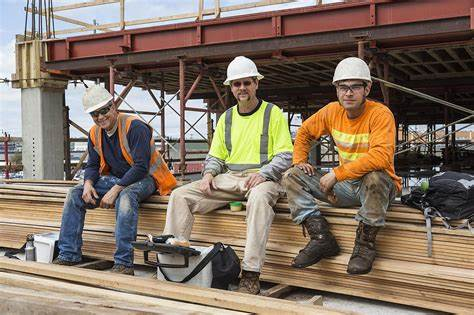

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [63]:
from IPython.display import display, Image

image_path = "/content/test 1.jpeg"

display(Image(filename=image_path))

In [48]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [49]:
best_model.to(device).predict(input_video_path).save(output_video_path)

#**Display the processed image**

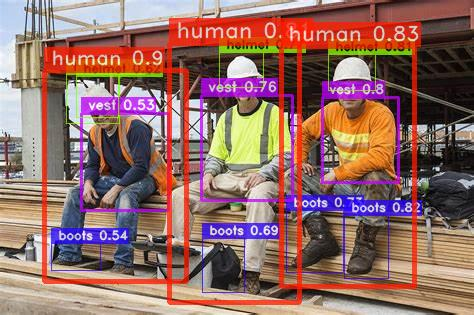

In [61]:
from IPython.display import display, Image

image_path = "/content/test1result.jpeg"

display(Image(filename=image_path))

#**Step 17: Testing on Video 2**

In [64]:
input_video_path = f"/content/demonew.png"
output_video_path = "detection.png"

In [40]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [41]:
best_model.to(device).predict(input_video_path).save(output_video_path)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[2024-03-04 15:37:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


#**Display the Output Video**

In [66]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
